<a href="https://colab.research.google.com/github/hjones234/INTRO-TO-AI-GROUP-20-PROJECT/blob/main/Copy_of_AIgroupproject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Section 1: Image import
!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download prosperchuks/amazonsatelliteimages
!unzip amazonsatelliteimages


Streaming output truncated to the last 5000 lines.
  inflating: train-jpg/train-jpg/train_55.jpg  
  inflating: train-jpg/train-jpg/train_550.jpg  
  inflating: train-jpg/train-jpg/train_5500.jpg  
  inflating: train-jpg/train-jpg/train_5501.jpg  
  inflating: train-jpg/train-jpg/train_5502.jpg  
  inflating: train-jpg/train-jpg/train_5503.jpg  
  inflating: train-jpg/train-jpg/train_5504.jpg  
  inflating: train-jpg/train-jpg/train_5505.jpg  
  inflating: train-jpg/train-jpg/train_5506.jpg  
  inflating: train-jpg/train-jpg/train_5507.jpg  
  inflating: train-jpg/train-jpg/train_5508.jpg  
  inflating: train-jpg/train-jpg/train_5509.jpg  
  inflating: train-jpg/train-jpg/train_551.jpg  
  inflating: train-jpg/train-jpg/train_5510.jpg  
  inflating: train-jpg/train-jpg/train_5511.jpg  
  inflating: train-jpg/train-jpg/train_5512.jpg  
  inflating: train-jpg/train-jpg/train_5513.jpg  
  inflating: train-jpg/train-jpg/train_5514.jpg  
  inflating: train-jpg/train-jpg/train_5515.jpg  
  i

In [ ]:
# Section 2: Import Libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from PIL import Image
import pandas as pd
import os


In [ ]:
# Section 3: Dataset Prep
class Satdata(Dataset):
    def __init__(self, csv_file, path, transform=None):
        self.data_frame = pd.read_csv(csv_file)
        self.path = path
        self.transform = transform

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, index):
        img_name = os.path.join(self.path, self.data_frame.iloc[index, 0])

        # Need this or we get an error about the files not existing
        if not img_name.endswith('.jpg'):
            img_name += '.jpg'

        image = Image.open(img_name).convert("RGB")


        label_str = self.data_frame.iloc[index, 1].lower()  # Convert to lowercase for case-insensitive matching

        # Check if the label contains specific keywords
        if 'primary' in label_str:
            label = 0  # Group with 'forested'
        elif 'cloudy' in label_str:
            label = 2  # Group with 'other'
        else:
            label = 1  # Group with 'deforested'

        if self.transform:
            image = self.transform(image)

        return image, label


In [ ]:
# Section 4: Transformations
transform = transforms.Compose([

    #transforms.Resize((224, 224)),
    transforms.Resize((128,128)),
    transforms.ToTensor(),
])

csv_file_path = '/content/train_v2.csv/train_v2.csv'
path_directory = '/content/train-jpg/train-jpg'

# Instantiate the dataset with the correct transformations
satellite_dataset = Satdata(csv_file=csv_file_path, path=path_directory, transform=transform)

# DataLoader instantiation
batch_size = 32
train_loader = DataLoader(satellite_dataset, batch_size=batch_size, shuffle=True)

# is this how to get the test data or does it need to be run through sat data too?
# Define the directory where your dataset is extracted
data_dir = "test-jpg"
data_dir_2 = "test-jpg-additional"

# Load the datasets using ImageFolder - now each item should be (image,label) where image represents the image and label represents the class label
test_dataset = datasets.ImageFolder(root=data_dir, transform=transform)
test_dataset2 = datasets.ImageFolder(root=data_dir_2, transform=transform)

test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)
test_loader2 = DataLoader(test_dataset2, batch_size=256, shuffle=False)


In [ ]:
# Section 5: Defining model / system architecture
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 5, padding=2)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 5, padding=2)
        self.fc1 = nn.Linear(32 * 64 * 64 // 4 , 120)  # Adjusted for 256x256 input
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 3)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 32 * 64 * 64 // 4)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = SimpleCNN()

In [ ]:
# Section 6: Optimiser & Loss Function
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()


In [ ]:
# Section 7: Training MIGHT WORK NOW? - think it works now (decreasing loss)
#model = SimpleCNN()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)


        #print(labels.size())
        #print(outputs.size())
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")


KeyboardInterrupt: 

In [ ]:
#model = SimpleCNN().to("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
#Section 7: With initialising on GPU rather than moving it to
#model = SimpleCNN().to("cuda" if torch.cuda.is_available() else "cpu")
# num_epochs = 10

# for epoch in range(num_epochs):
#     model.train()
#     running_loss = 0.0
#     for images, labels in train_loader:
#         images, labels = images.to(device), labels.to(device)
#         optimizer.zero_grad()
#         outputs = model(images)


#         #print(labels.size())
#         #print(outputs.size())
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()
#         running_loss += loss.item()
#     print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")



KeyboardInterrupt: 

Run 1, Epoch 1/10, Loss: 0.19671032485357032, Accuracy: 93.64608809506164
Run 1, Epoch 2/10, Loss: 0.17544954921350825, Accuracy: 94.14511228044171
Run 1, Epoch 3/10, Loss: 0.16708790437012852, Accuracy: 94.30568936979668
Run 1, Epoch 4/10, Loss: 0.16660447234744316, Accuracy: 94.3748610390573
Run 1, Epoch 5/10, Loss: 0.16384720932839533, Accuracy: 94.3427456211863
Run 1, Epoch 6/10, Loss: 0.1620257283133922, Accuracy: 94.49838187702265
Run 1, Epoch 7/10, Loss: 0.15972584655799207, Accuracy: 94.41932854072482
Run 1, Epoch 8/10, Loss: 0.15488685532381, Accuracy: 94.50085229378196
Run 1, Epoch 9/10, Loss: 0.15489085024671828, Accuracy: 94.56261271276465
Run 1, Epoch 10/10, Loss: 0.15214441495178185, Accuracy: 94.59719854739494
Run 2, Epoch 1/10, Loss: 0.15049943336333504, Accuracy: 94.60460979767286
Run 2, Epoch 2/10, Loss: 0.15229273561918336, Accuracy: 94.61943229822872
Run 2, Epoch 3/10, Loss: 0.14749743481140892, Accuracy: 94.66142938313693
Run 2, Epoch 4/10, Loss: 0.1416211027501099

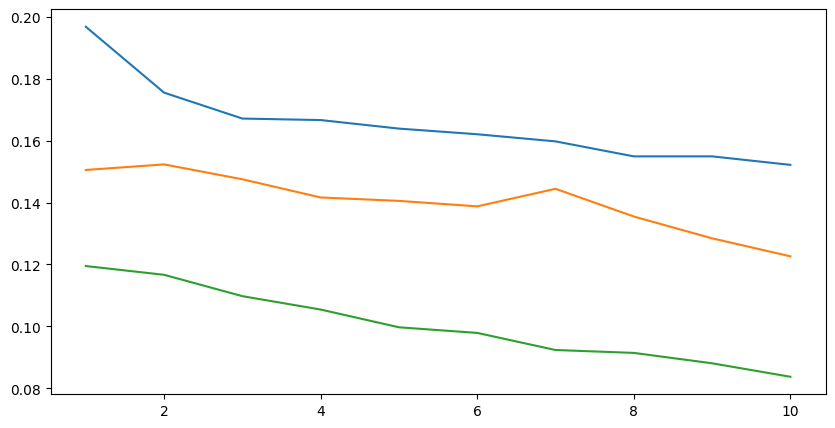

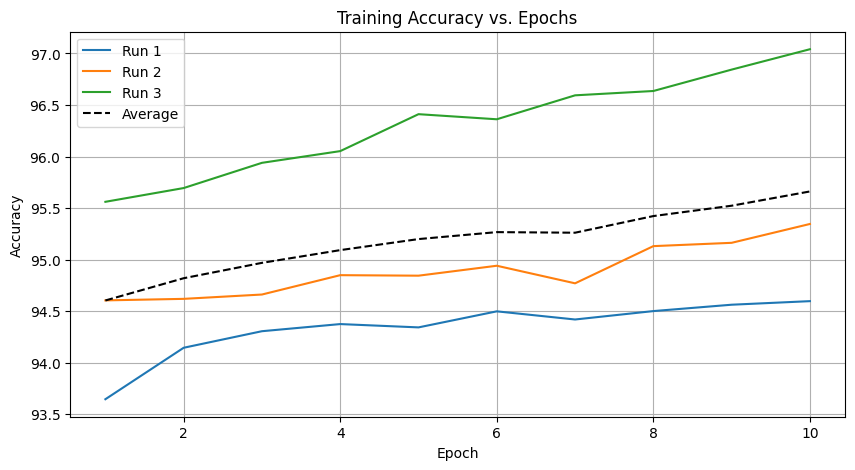

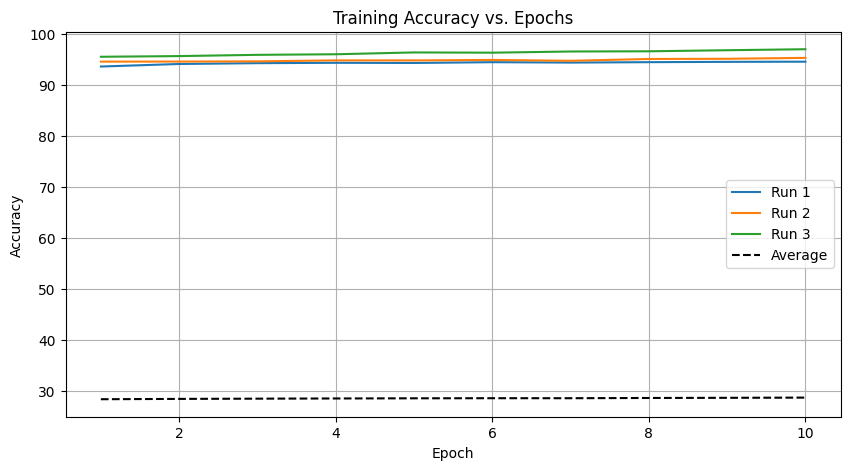

In [ ]:
#plot

import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 10
num_runs = 3

all_train_losses = []  # List to store training loss for each run
all_train_accuracies = []  # List to store training accuracy for each run

for run in range(num_runs):
    # Initialize model, optimizer, etc. if needed

    train_losses = []  # to store the training loss values for each epoch
    train_accuracies = []  # to store the training accuracy values for each epoch

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Calculate average training loss for the epoch and store it
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        # Calculate training accuracy for the epoch and store it
        train_accuracy = 100 * correct / total
        train_accuracies.append(train_accuracy)

        print(f"Run {run + 1}, Epoch {epoch + 1}/{num_epochs}, Loss: {train_loss}, Accuracy: {train_accuracy}")

    # Append the training loss and accuracy for this run to all_train_losses and all_train_accuracies
    all_train_losses.append(train_losses)
    all_train_accuracies.append(train_accuracies)

# Plotting the training loss vs. epochs
plt.figure(figsize=(10, 5))
for i, losses in enumerate(all_train_losses):
    plt.plot(range(1, num_epochs + 1), losses, label=f'Run {i + 1}')

# Calculate average loss across all runs
avg_loss = [sum(losses) / num_runs for losses in zip(*all_train_losses)]


# Calculate average accuracy across all runs for each epoch
avg_accuracy = [sum(accuracies) / num_runs for accuracies in zip(*all_train_accuracies)]

# Plotting the training accuracy vs. epochs
plt.figure(figsize=(10, 5))
for i, accuracies in enumerate(all_train_accuracies):
    plt.plot(range(1, num_epochs + 1), accuracies, label=f'Run {i + 1}')

plt.plot(range(1, num_epochs + 1), avg_accuracy, label='Average', linestyle='--', color='black')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy vs. Epochs')
plt.legend()
plt.grid(True)
plt.show()


# Plotting the training accuracy vs. epochs
plt.figure(figsize=(10, 5))
for i, accuracies in enumerate(all_train_accuracies):
    plt.plot(range(1, num_epochs + 1), accuracies, label=f'Run {i + 1}')

# Calculate average accuracy across all runs
avg_accuracy = [sum(accuracies) / num_epochs for accuracies in zip(*all_train_accuracies)]
plt.plot(range(1, num_epochs + 1), avg_accuracy, label='Average', linestyle='--', color='black')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy vs. Epochs')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
#PLOTTING TEST VS. TRAIN ACCURACY AND LOSS OVER EPOCHS

import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Define your model, criterion, optimizer, train_loader, test_loader, and test_loader2 here

# 1. Training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 4
num_runs = 1

all_train_losses = []  # List to store training loss for each run
all_train_accuracies = []  # List to store training accuracy for each run
all_test_losses = []  # List to store test loss for each run
all_test_accuracies = []  # List to store test accuracy for each run

for run in range(num_runs):
    train_losses = []  # to store the training loss values for each epoch
    train_accuracies = []  # to store the training accuracy values for each epoch
    test_losses = []  # to store the test loss values for each epoch
    test_accuracies = []  # to store the test accuracy values for each epoch

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        train_accuracy = 100 * correct / total
        train_accuracies.append(train_accuracy)

        print(f"Run {run + 1}, Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss}, Train Accuracy: {train_accuracy}")

        # Evaluate model on test set
        model.eval()
        test_correct = 0
        test_total = 0
        test_loss = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                test_loss += criterion(outputs, labels).item()
                _, predicted = torch.max(outputs.data, 1)
                test_total += labels.size(0)
                test_correct += (predicted == labels).sum().item()

        test_loss /= len(test_loader)
        test_losses.append(test_loss)
        test_accuracy = 100 * test_correct / test_total
        test_accuracies.append(test_accuracy)
        print(f"Run {run + 1}, Epoch {epoch + 1}/{num_epochs}, Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

    all_train_losses.append(train_losses)
    all_train_accuracies.append(train_accuracies)
    all_test_losses.append(test_losses)
    all_test_accuracies.append(test_accuracies)

# Plotting
plt.figure(figsize=(10, 5))

# Plotting train accuracy
for i, accuracies in enumerate(all_train_accuracies):
    plt.plot(range(1, num_epochs + 1), accuracies, label=f'Train Accuracy - Run {i + 1}')

# Plotting test accuracy
for i, accuracies in enumerate(all_test_accuracies):
    plt.plot(range(1, num_epochs + 1), accuracies, label=f'Test Accuracy - Run {i + 1}', linestyle='--')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epochs')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))

# Plotting train loss
for i, losses in enumerate(all_train_losses):
    plt.plot(range(1, num_epochs + 1), losses, label=f'Train Loss - Run {i + 1}')

# Plotting test loss
for i, losses in enumerate(all_test_losses):
    plt.plot(range(1, num_epochs + 1), losses, label=f'Test Loss - Run {i + 1}', linestyle='--')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epochs')
plt.legend()
plt.grid(True)
plt.show()


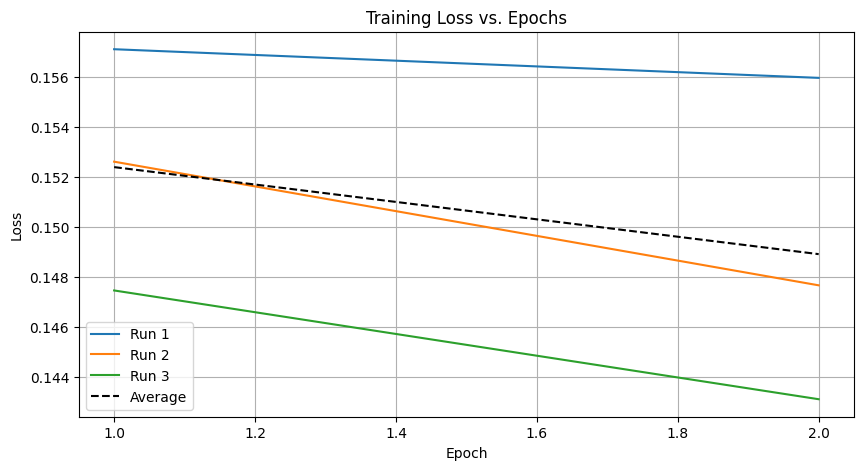

In [ ]:
# Calculate average loss across all runs for each epoch
avg_loss = [sum(losses) / num_runs for losses in zip(*all_train_losses)]

# Plotting the training loss vs. epochs
plt.figure(figsize=(10, 5))
for i, losses in enumerate(all_train_losses):
    plt.plot(range(1, num_epochs + 1), losses, label=f'Run {i + 1}')

plt.plot(range(1, num_epochs + 1), avg_loss, label='Average', linestyle='--', color='black')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss vs. Epochs')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Section 8: False Negatives vs. False Positives Plot
false_negatives = []  # to store the number of false negatives for each epoch
false_positives = []  # to store the number of false positives for each epoch

model.eval()  # switch to evaluation mode

for epoch in range(num_epochs):
    # Initialize counters for false negatives and false positives for this epoch
    fn_epoch = 0
    fp_epoch = 0

    # Iterate over the test dataset to calculate false negatives and false positives
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        # Calculate false negatives and false positives for this batch
        fn_epoch += ((predicted == 0) & (labels != predicted)).sum().item()
        fp_epoch += ((predicted == 1) & (labels != predicted)).sum().item()

    # Append the total false negatives and false positives for this epoch
    false_negatives.append(fn_epoch)
    false_positives.append(fp_epoch)

# Plotting False Negatives vs. False Positives
plt.plot(range(1, num_epochs + 1), false_negatives, label='False Negatives')
plt.plot(range(1, num_epochs + 1), false_positives, label='False Positives')
plt.xlabel('Epoch')
plt.ylabel('Count')
plt.title('False Negatives vs. False Positives')
plt.legend()
plt.show()



KeyboardInterrupt: 

In [ ]:
import torch
import pandas as pd

# Assuming the rest of your model, criterion, optimizer, and train_loader are defined above this

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 10  # Set to 10 epochs

# DataFrame to store training results for each epoch
df_results = pd.DataFrame(columns=['Epoch', 'Training Loss', 'Training Accuracy'])

# Training loop for epochs
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Calculate average training loss for the epoch
    train_loss = running_loss / len(train_loader)

    # Calculate training accuracy for the epoch
    train_accuracy = 100 * correct / total

    # Append to DataFrame
    df_results = df_results.append({
        'Epoch': epoch + 1,
        'Training Loss': train_loss,
        'Training Accuracy': train_accuracy
    }, ignore_index=True)

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {train_loss}, Accuracy: {train_accuracy}")

# Display the table
print(df_results)


<ipython-input-11-7368d828fa17>:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append({


Epoch 1/10, Loss: 0.13891347141259097, Accuracy: 94.80718397193607


<ipython-input-11-7368d828fa17>:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append({


Epoch 2/10, Loss: 0.135070599731345, Accuracy: 95.00234689592135


<ipython-input-11-7368d828fa17>:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append({


Epoch 3/10, Loss: 0.13100354294550307, Accuracy: 95.21727315398108


<ipython-input-11-7368d828fa17>:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append({


Epoch 4/10, Loss: 0.1250730314582822, Accuracy: 95.38526149361397


<ipython-input-11-7368d828fa17>:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append({


Epoch 5/10, Loss: 0.12176258855723876, Accuracy: 95.60512858519232


<ipython-input-11-7368d828fa17>:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append({


Epoch 6/10, Loss: 0.11361412704156587, Accuracy: 95.82005484325205


<ipython-input-11-7368d828fa17>:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append({


Epoch 7/10, Loss: 0.11023415907087328, Accuracy: 95.99792484992219


<ipython-input-11-7368d828fa17>:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append({


Epoch 8/10, Loss: 0.10544405748548627, Accuracy: 96.11403443760962


<ipython-input-11-7368d828fa17>:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append({


Epoch 9/10, Loss: 0.09975206180413074, Accuracy: 96.28449319400183
Epoch 10/10, Loss: 0.09470249049866153, Accuracy: 96.52659403641394
   Epoch  Training Loss  Training Accuracy
0    1.0       0.138913          94.807184
1    2.0       0.135071          95.002347
2    3.0       0.131004          95.217273
3    4.0       0.125073          95.385261
4    5.0       0.121763          95.605129
5    6.0       0.113614          95.820055
6    7.0       0.110234          95.997925
7    8.0       0.105444          96.114034
8    9.0       0.099752          96.284493
9   10.0       0.094702          96.526594


<ipython-input-11-7368d828fa17>:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append({


In [ ]:
import torch
import pandas as pd

# Assuming the rest of your model, criterion, optimizer, and test_loader are defined above this

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()  # Set the model to evaluation mode

num_epochs = 10  # Assuming you want to log metrics across epochs, if applicable

# DataFrame to store test results for each epoch (if you're evaluating after each training epoch)
df_test_results = pd.DataFrame(columns=['Epoch', 'Test Loss', 'Test Accuracy'])

# Assuming you have a loop somewhere for training, and you want to evaluate after each epoch
for epoch in range(num_epochs):
    with torch.no_grad():  # No gradients needed for evaluation
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Calculate average test loss for the epoch
        test_loss = running_loss / len(test_loader)

        # Calculate test accuracy for the epoch
        test_accuracy = 100 * correct / total

        # Append to DataFrame
        df_test_results = df_test_results.append({
            'Epoch': epoch + 1,
            'Test Loss': test_loss,
            'Test Accuracy': test_accuracy
        }, ignore_index=True)

        print(f"Epoch {epoch + 1}/{num_epochs}, Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

# Display the table
print(df_test_results)


<ipython-input-12-c601b496c5b2>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_results = df_test_results.append({


Epoch 1/10, Test Loss: 0.09528152977333129, Test Accuracy: 95.70680370798397


<ipython-input-12-c601b496c5b2>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_results = df_test_results.append({


Epoch 2/10, Test Loss: 0.09528152977333129, Test Accuracy: 95.70680370798397


<ipython-input-12-c601b496c5b2>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_results = df_test_results.append({


Epoch 3/10, Test Loss: 0.09528152977333129, Test Accuracy: 95.70680370798397


<ipython-input-12-c601b496c5b2>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_results = df_test_results.append({


Epoch 4/10, Test Loss: 0.09528152977333129, Test Accuracy: 95.70680370798397


<ipython-input-12-c601b496c5b2>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_results = df_test_results.append({


Epoch 5/10, Test Loss: 0.09528152977333129, Test Accuracy: 95.70680370798397


<ipython-input-12-c601b496c5b2>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_results = df_test_results.append({


Epoch 6/10, Test Loss: 0.09528152977333129, Test Accuracy: 95.70680370798397


<ipython-input-12-c601b496c5b2>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_results = df_test_results.append({


Epoch 7/10, Test Loss: 0.09528152977333129, Test Accuracy: 95.70680370798397


<ipython-input-12-c601b496c5b2>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_results = df_test_results.append({


Epoch 8/10, Test Loss: 0.09528152977333129, Test Accuracy: 95.70680370798397


<ipython-input-12-c601b496c5b2>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_results = df_test_results.append({


Epoch 9/10, Test Loss: 0.09528152977333129, Test Accuracy: 95.70680370798397
Epoch 10/10, Test Loss: 0.09528152977333129, Test Accuracy: 95.70680370798397
   Epoch  Test Loss  Test Accuracy
0    1.0   0.095282      95.706804
1    2.0   0.095282      95.706804
2    3.0   0.095282      95.706804
3    4.0   0.095282      95.706804
4    5.0   0.095282      95.706804
5    6.0   0.095282      95.706804
6    7.0   0.095282      95.706804
7    8.0   0.095282      95.706804
8    9.0   0.095282      95.706804
9   10.0   0.095282      95.706804


<ipython-input-12-c601b496c5b2>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_results = df_test_results.append({


In [ ]:
# Test function (works i think, test accuracy isn't 100% anymore which should be correct but I'm not sure - was getting 95% ish)
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy on the test set: {accuracy:.2f}%')

# Call the test function after training
test_model(model, test_loader)
test_model(model, test_loader2)

KeyboardInterrupt: 

The next section is on Image Segmentation:

In [ ]:
# Section 1: Image import
!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d quadeer15sh/augmented-forest-segmentation
!unzip augmented-forest-segmentation

Streaming output truncated to the last 5000 lines.
  inflating: Forest Segmented/Forest Segmented/masks/119079_mask_73.jpg  
  inflating: Forest Segmented/Forest Segmented/masks/119079_mask_77.jpg  
  inflating: Forest Segmented/Forest Segmented/masks/119079_mask_78.jpg  
  inflating: Forest Segmented/Forest Segmented/masks/119079_mask_80.jpg  
  inflating: Forest Segmented/Forest Segmented/masks/119079_mask_81.jpg  
  inflating: Forest Segmented/Forest Segmented/masks/119079_mask_87.jpg  
  inflating: Forest Segmented/Forest Segmented/masks/119079_mask_88.jpg  
  inflating: Forest Segmented/Forest Segmented/masks/122104_mask_00.jpg  
  inflating: Forest Segmented/Forest Segmented/masks/122104_mask_01.jpg  
  inflating: Forest Segmented/Forest Segmented/masks/122104_mask_03.jpg  
  inflating: Forest Segmented/Forest Segmented/masks/122104_mask_04.jpg  
  inflating: Forest Segmented/Forest Segmented/masks/122104_mask_11.jpg  
  inflating: Forest Segmented/Forest Segmented/masks/122104_m

In [ ]:
from glob import glob
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [ ]:
# Section 2: Dataset Prep
class Image_seg_data(Dataset):
  #note the random_state bit plants a seed
    def __init__(self, csv_file, pathsat, pathmasks, transform=None,train=True, test_size=0.4): #random_state=42):
        self.data_frame = pd.read_csv(csv_file)
        self.path = pathsat
        self.pathmask = pathmasks
        self.transform = transform


         # Split the data into training and testing sets
        train_data, test_data = train_test_split(self.data_frame, test_size=test_size) #, random_state=random_state)

        # Use either training or testing data based on the 'train' parameter
        if train:
            self.data = train_data
        else:
            self.data = test_data

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, index):
        img_name = os.path.join(self.path, self.data_frame.iloc[index, 0])

        # Need this or we get an error about the files not existing
        if not img_name.endswith('.jpg'):
            img_name += '.jpg'

        stat_image = Image.open(img_name).convert("RGB")

  #Using the label bit from previous section to find associated mask
        #label_str = self.data_frame.iloc[index, 1]  # Convert to lowercase for case-insensitive matching

        # I BELIEVE SOMETHING IS WRONG WITH THIS BIT WHICH IS LEADING TO THE DIMENSIONS BEING WRONG.
        mask_name = os.path.join(self.pathmask, self.data_frame.iloc[index, 1] )
        if not mask_name.endswith('.jpg'):
            mask_name += '.jpg'

        mask_image = Image.open(mask_name).convert("RGB")

        if self.transform:
            stat_image = self.transform(stat_image)
            mask_image = self.transform(mask_image)

        return stat_image, mask_image

In [ ]:
# Section 4: Transformations and Creating train and test data sets
transform2 = transforms.Compose([

    transforms.Resize((256, 256)),
    #transforms.Resize((128,128)),
    transforms.ToTensor(),
])


csv_file_path2 = '/content/meta_data.csv'
path_directory2 = '/content/Forest Segmented/Forest Segmented/images'
path_masks = '/content/Forest Segmented/Forest Segmented/masks'

# Instantiate the dataset with the correct transformations splitting into train and test datsets

train_dataset2 = Image_seg_data(csv_file=csv_file_path2, pathsat=path_directory2, pathmasks = path_masks , transform= transform2, train=True)
test_dataset2 = Image_seg_data(csv_file=csv_file_path2, pathsat=path_directory2 , pathmasks = path_masks, transform= transform2, train=False)

# DataLoader instantiation
batch_size = 32
train_loader2 = DataLoader(train_dataset2, batch_size=32, shuffle=True)

test_loader2 = DataLoader(test_dataset2, batch_size=32, shuffle=False)


In [ ]:
#Section 5 making the Unet model

class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()

        # Define the encoder (contracting path)
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace = True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Define the decoder (expansive path)
        self.decoder = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace = True),
            nn.Conv2d(64, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace = True),
            #not sure what this does it might be the reason th dimensions are wrong
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        )

    def forward(self, x):
        # Encoder

        x1 = self.encoder(x)
        # Decoder
        x2 = self.decoder(x1)

        return x2

# Set the number of input and output channels based on your data
in_channels = 3  # Assuming RGB images
out_channels = 1  # Output is a binary mask, adjust if needed

# Create an instance of the U-Net model
mas_model = UNet(in_channels, out_channels)


In [ ]:
# Section 6: Optimiser & Loss Function
#optimizer = optim.Adam(mas_model.parameters(), lr=0.01)
#optimizer = optim.Adamax(mas_model.parameters(), lr=0.001)


optimizer = optim.SGD(mas_model.parameters(), lr=0.01, momentum=0.99, weight_decay=0.0001)  # You can adjust lr and momentum as needed
#Using this one for bianry apparently
criterion2 = nn.BCEWithLogitsLoss()

Currently trying to figure out how to do the loss taking into account the images going in are 3 dim and then it is a binary masks - I have figured out that it is something wrong with the getitem bit of the class that is leading to the targets to be that dimension.

In [ ]:
#Galit's tryb
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mas_model.to(device)
num_epochs = 10

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

for epoch in range(num_epochs):
    mas_model.train()
    running_loss = 0

    for inputs, targets in train_loader2:
        optimizer.zero_grad()

        # Move input tensors to the same device as the model
        inputs = inputs.to(device)
        targets = targets.to(device)

        outputs = mas_model(inputs)

        # Assuming your original target tensor has 3 channels, convert it to a single-channel binary mask
        targets = targets[:, 0, :, :].unsqueeze(1)  # Assuming the first channel represents the mask

        # Convert the output to a single-channel binary mask
        outputs_sigmoid = torch.sigmoid(outputs)
        outputs_binary = (outputs_sigmoid > 0.5).float()  # Thresholding at 0.5 to get binary mask
        breakpoint()\
        # Ensure that targets require gradients
        #targets.requires_grad = True

        loss = criterion2(outputs_binary, targets)
        loss.backward()
        optimizer.step()

        # Update the running loss
        running_loss += loss.item() #* inputs.size(0)  # Multiply by batch size

    # Print the average loss for the epoch
    epoch_loss = running_loss / len(train_loader2.dataset)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss}")

    # Step the learning rate scheduler
    scheduler.step()


PYDEV DEBUGGER WARNING:
sys.settrace() should not be used when the debugger is being used.
This may cause the debugger to stop working correctly.
If this is needed, please check: 
http://pydev.blogspot.com/2007/06/why-cant-pydev-debugger-work-with.html
to see how to restore the debug tracing back correctly.
Call Location:
  File "/usr/lib/python3.10/bdb.py", line 336, in set_trace
    sys.settrace(self.trace_dispatch)



> <ipython-input-12-4fd5f19b2b6f>(31)<cell line: 8>()
     29         #targets.requires_grad = True
     30 
---> 31         loss = criterion2(outputs_binary, targets)
     32         loss.backward()
     33         optimizer.step()




PYDEV DEBUGGER WARNING:
sys.settrace() should not be used when the debugger is being used.
This may cause the debugger to stop working correctly.
If this is needed, please check: 
http://pydev.blogspot.com/2007/06/why-cant-pydev-debugger-work-with.html
to see how to restore the debug tracing back correctly.
Call Location:
  File "/usr/lib/python3.10/bdb.py", line 361, in set_quit
    sys.settrace(None)


PYDEV DEBUGGER WARNING:
sys.settrace() should not be used when the debugger is being used.
This may cause the debugger to stop working correctly.
If this is needed, please check: 
http://pydev.blogspot.com/2007/06/why-cant-pydev-debugger-work-with.html
to see how to restore the debug tracing back correctly.
Call Location:
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/debugger.py", line 1075, in cmdloop
    sys.settrace(None)



--KeyboardInterrupt--

KeyboardInterrupt: Interrupted by user


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [ ]:
# Test function (works i think, test accuracy isn't 100% anymore which should be correct but I'm not sure - was getting 95% ish)
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy on the test set: {accuracy:.2f}%')

# Call the test function after training
test_model(model, test_loader)
test_model(model, test_loader2)